# Lab 5 — MPDATA iterative correction

#### Tomasz Ogiołda

### Goal

Iterative correction analysis of MPDATA scheme.

In [130]:
import numpy as np
from matplotlib import pyplot as plt

%config InlineBackend.figure_formats = ['svg']

In [131]:
class shift:
    def __init__(self, *, add, sub):
        self.add = add
        self.sub = sub
    def __radd__(self, i): 
        return slice(i.start + self.add, i.stop + self.add)
    def __rsub__(self, i): 
        return slice(i.start - self.sub, i.stop - self.sub)

one = shift(add=1, sub=1)
hlf = shift(add=0, sub=1)

def F(psi_l, psi_r, C):
    return .5 * (C + abs(C)) * psi_l + \
           .5 * (C - abs(C)) * psi_r

def upwind(psi, i, C):
    psi[i] = psi[i] - (
        F(psi[i      ], psi[i + one], C[i + hlf]) -
        F(psi[i - one], psi[i      ], C[i - hlf]) 
    )
    
def psi_0(x: np.ndarray, x0: float = 0, a: float = 1, sigma: float = 20):
    return a * np.exp(-(x-x0)**2 / 2 / sigma**2)

def relative_err(numerical: np.ndarray, expected: np.ndarray):
    assert len(numerical) == len(expected), "Actual and Expected value len not matched"

    return np.mean(np.abs(expected - numerical / expected))


In [132]:
def corrective_C(psi, i, C):
    return (np.abs(C[i - hlf]) - C[i - hlf]**2) * (psi[i] - psi[i - one]) / (psi[i] + psi[i - one])

def solve_mpdata(*, nt: int, C: float, psi: np.ndarray, corrections: int = 1):
    for _ in range(nt):
        i = slice(1, len(C))
        upwind(psi, i, C)
        corr_C = corrective_C(psi, slice(1, len(psi)), C)
        for _ in range(corrections):
            upwind(psi, i, corr_C)
            corr_C = corrective_C(psi, slice(1, len(psi)), corr_C)
 
    return psi


In [133]:
def plot(x, **kwargs):
    for label, data in kwargs.items():
        plt.step(x, data, label=label, where='mid')

## Iterative MPDATA scheme

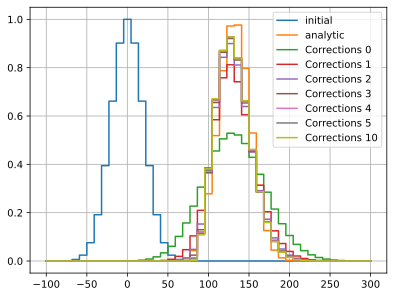

In [134]:
u = 2
t_max = 66

nx = 45
nt = 100
dt = t_max / nt
x, dx = np.linspace(-100, 300, nx, retstep=True)

mpdata_results = dict()
correction_steps = [0, 1, 2, 3, 4, 5, 10]

for corrs in correction_steps:
    mpdata_results[f'Corrections {corrs}'] = solve_mpdata(
        nt=nt,
        C=np.full(nx-1, u * dt / dx),
        psi=psi_0(x),
        corrections=corrs
    )

plot(
    x=x,
    initial=psi_0(x),
    analytic=psi_0(x - u * t_max),
    **mpdata_results
)

plt.legend()
plt.grid()


## Error analysis

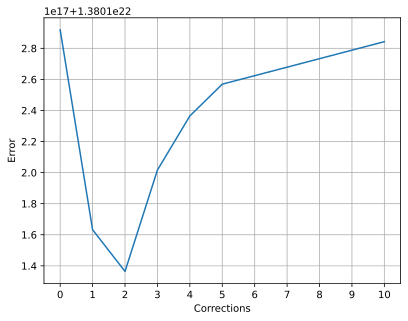

In [136]:
errs = []
analytical = psi_0(x - u * t_max)
for _, numerical in mpdata_results.items():
    errs.append(relative_err(numerical=numerical, expected=analytical))

plt.plot(correction_steps, errs)
plt.xlabel("Corrections")
plt.ylabel("Error")
plt.xticks(ticks=range(min(correction_steps), max(correction_steps)+1))
plt.grid()

## Conclusions

The error analysis demonstrates an error minimization behavior up to 2 corrective iterations, after which the error begins to increase 
again. Over-correcting (more than 2 iterations) introduces numerical artifacts or overfitting-like behavior, degrading accuracy.